### Informações sobre atributos:
1) __id__: identificador único
2) __gênero__: "Masculino", "Feminino" ou "Outro"
3) __idade__: idade do paciente
4) __hipertensão__: 0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão
5) __doença cardíaca__: 0 se o paciente não tiver doença cardíaca, 1 se o paciente tiver doença cardíaca
6) __já casado__: "Não" ou "Sim"
7) __tipo de trabalho__: "crianças"(`children`), "Funcionário público"(`Govt_jov`), "Nunca trabalhou"(`Never_worked`), "Privado"(`Private`) ou "Autônomo"(`Self-employed`)
8) __tipo de residência__: "Rural" ou "Urbana"
9) __nível médio de glicose__: nível médio de glicose no sangue
10) __IMC__: índice de massa corporal
11) __status de tabagismo__: "ex-fumante"(`formerly smoked`), "nunca fumou"(`formerly smoked`), "fuma"(`smokes`) ou "Desconhecido"(`Unknown`)
12) __AVC__: 1 se o paciente teve um AVC ou 0 se não teve

In [259]:
import copy 
import scipy
import warnings
import pandas as pd
import numpy as np
import seaborn as sea 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [260]:
warnings.filterwarnings('ignore',category=FutureWarning)

In [261]:
data = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv',sep=',')

In [262]:
data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


## Analise dos dados

In [263]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


> Nesse conjunto de daddos para valores númericos continuos irei fazer a padronização dos dados

In [264]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

> quantidade de valores unicos de cada atributo

In [265]:
valoresNulos = (pd.concat([data.isna().nunique(),data.isnull().nunique()] ,axis=1))
valoresNulos.columns = ['NaN','NULL']
valoresNulos

,NaN,NULL
id,1,1
gender,1,1
age,1,1
hypertension,1,1
heart_disease,1,1
ever_married,1,1
work_type,1,1
Residence_type,1,1
avg_glucose_level,1,1
bmi,2,2


In [266]:
data.loc[data['bmi'].isna()==True]['stroke'].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [267]:
data.drop(index = data.loc[data['bmi'].isna()==True].index , inplace=True)

> Será removido para a analises depois decido oq fazer com esses valores nulos

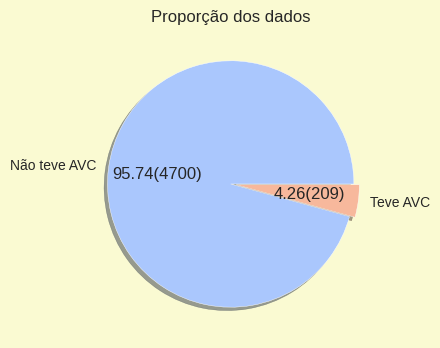

In [268]:
pizza = data['stroke'].value_counts()

plt.figure(figsize=(6,4),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= ['Não teve AVC','Teve AVC'] , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=2),shadow=True,explode=(0,0.045),pctdistance=0.6)
plt.title('Proporção dos dados')
plt.show()

> No preprocessamento dos dados para a classificação se faz necessario o balanceamento dos dados , a mais valores para pessoas que não teve Avc para as que tiveram

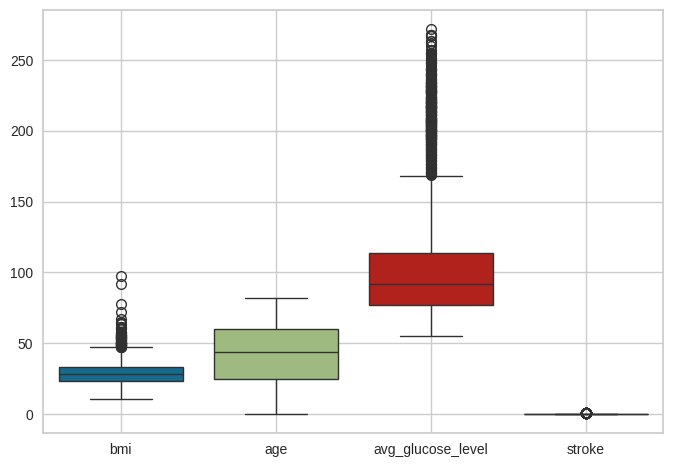

In [269]:
sea.boxplot( data[['bmi','age','avg_glucose_level','stroke']])
plt.grid(True)
plt.show()

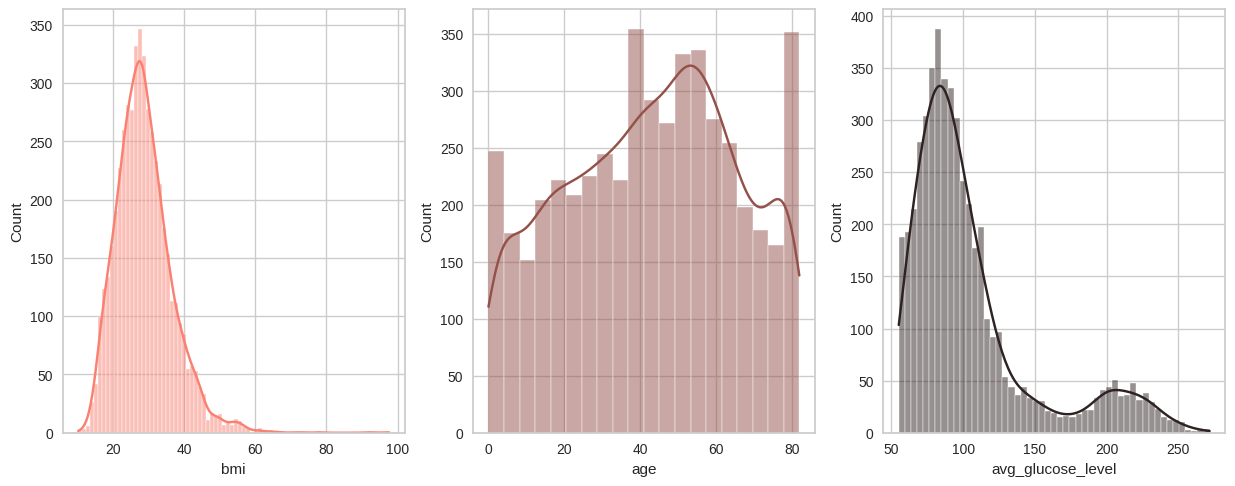

In [270]:
fig , ax = plt.subplots(1,3)
fig.set_figwidth(15)
colors   = sea.color_palette('dark:salmon_r',n_colors=3)
index    = 0
for coluna in ['bmi','age','avg_glucose_level']:
    sea.histplot(data[coluna], ax=ax[index] ,color=colors[index] , kde=True); index +=1
plt.show()

> Há outlier

In [271]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]
freq  = pd.cut(x = data['bmi'] , bins=bins ,labels=labels)
hist  = pd.concat([freq,data[['stroke']]],axis=1)
hist  = hist.groupby(by=['bmi'])['stroke'].value_counts().reset_index()

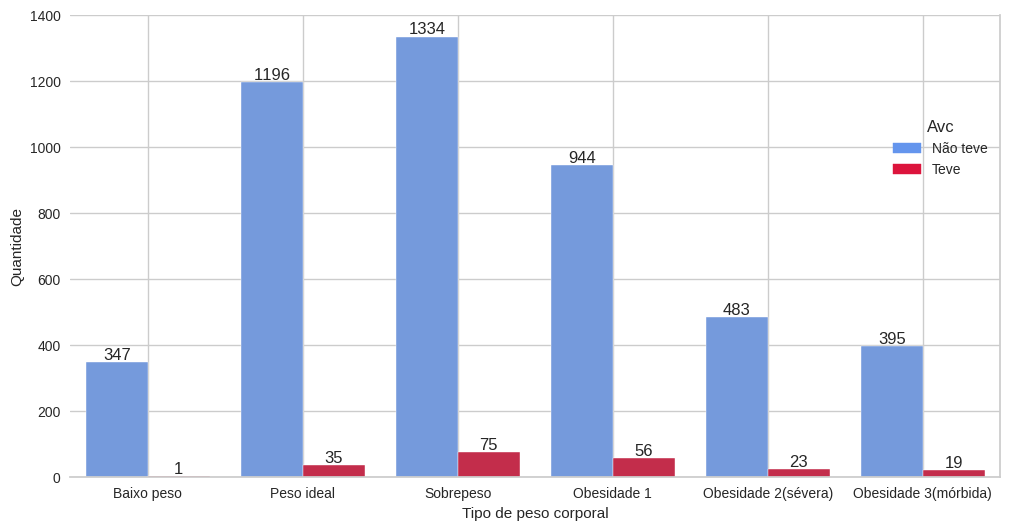

In [272]:
fig ,ax = plt.subplots(1,1)
fig.set_figwidth(12)
fig.set_figheight(6)

colors  = ['#6495ED','#DC143C'] 
bar = sea.barplot(x = hist['bmi'] ,y=hist['count'],hue=hist['stroke'],palette=colors ,ax=ax)
bar.bar_label( bar.containers[0] )
bar.bar_label( bar.containers[1] )

ax.set_ylabel('Quantidade')
ax.set_xlabel('Tipo de peso corporal')
ax.spines[['top','left']].set_visible(False)
legends = []
for value, color in zip(['Não teve','Teve'], colors): legends.append(mpatches.Patch(color=color, label=value))

ax.legend(title='Avc',handles=legends,bbox_to_anchor=(1,0.8,0,0))
plt.grid(True)
plt.show()

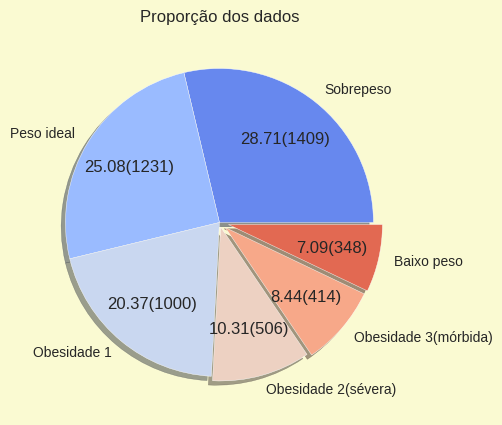

In [273]:
pizza = freq.value_counts()

plt.figure(figsize=(8,5),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= pizza.index , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=6),shadow=True,pctdistance=0.69,explode=(0,0,0,0.03,0.05,0.06))
plt.title('Proporção dos dados')
plt.show()

In [274]:
data['gender'].value_counts().reset_index()

,gender,count
0,Female,2897
1,Male,2011
2,Other,1


In [275]:
data.drop( index = data.loc[data['gender']=='Other'].index , inplace=True)

> No atributo `gender` o valores other só aparece uma vez , será removido

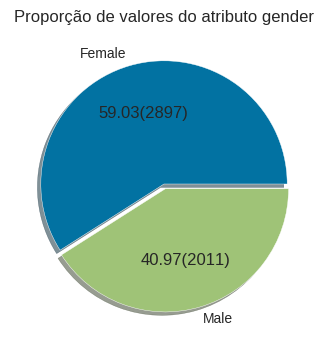

In [276]:
pizza = data['gender'].value_counts()

plt.figure(figsize=(6,4))
plt.pie(x = pizza.values , labels = pizza.index , explode=(0,0.04),autopct=lambda x: '{:.2f}({:.0f})'.format(x,((x*sum(pizza.values))/100)) , shadow=True)
plt.title('Proporção de valores do atributo gender')
plt.show()

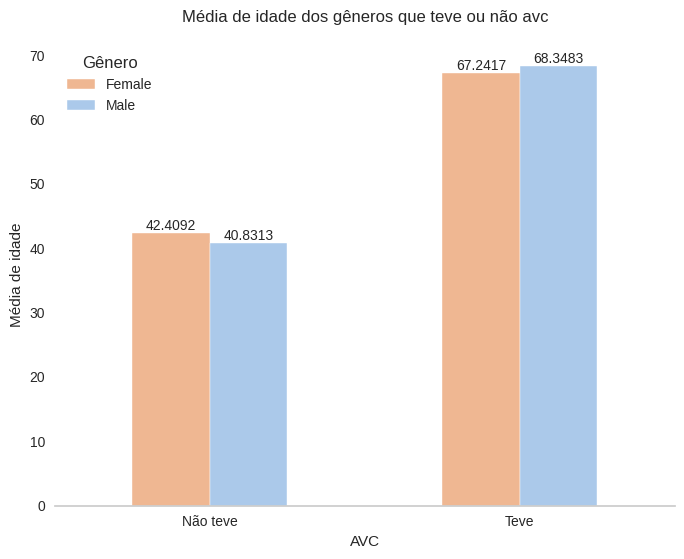

In [277]:
resultado = data.groupby(by=['gender','stroke'])['age'].mean().reset_index()

fig , ax = plt.subplots(1,1)
fig.set_figwidth(8)
fig.set_figheight(6)

bar = sea.barplot(x = resultado['stroke'] , y=resultado['age'] ,hue = resultado['gender'],palette=sea.color_palette('pastel')[0:2][::-1],width=0.5,ax=ax)
bar.bar_label(bar.containers[0], fontsize=10)
bar.bar_label(bar.containers[1], fontsize=10)

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.spines[['right','top','left']].set_visible(False)
plt.legend(title='Gênero')
plt.title('Média de idade dos gêneros que teve ou não avc',y=1.029)
plt.xticks([0,1],['Não teve','Teve'])
plt.ylabel('Média de idade')
plt.xlabel('AVC')

plt.show()

In [278]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]

freq  = pd.cut(x = data['bmi'] , bins=bins ,labels=labels)

resultado = pd.concat([freq,data[['work_type','stroke']]],axis=1)

In [279]:
gropbyresultado = resultado.groupby(by=['work_type'])['bmi'].value_counts().reset_index()

/tmp/ipykernel_66943/3661486926.py:7: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  bar = sea.barplot(x=gropbyresultado['count'],y=gropbyresultado['work_type'],hue=gropbyresultado['bmi'],palette=palette,ax=ax)


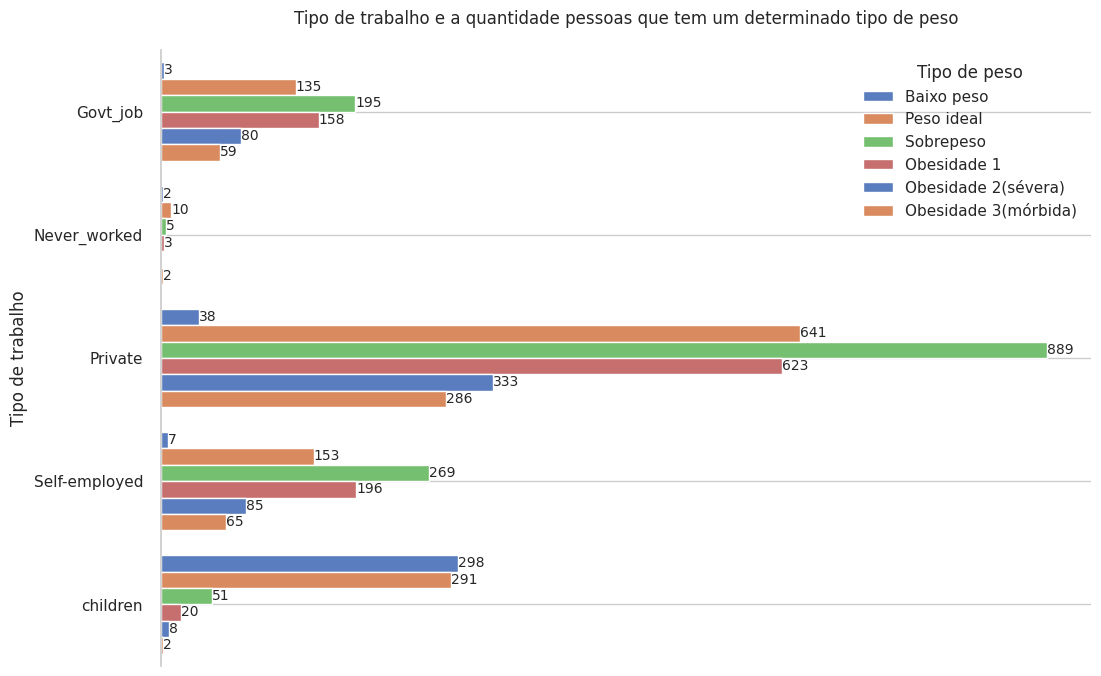

In [280]:

sea.set_theme(style="whitegrid")
fig , ax = plt.subplots(1,1)
fig.set_figwidth(12)
fig.set_figheight(8)

palette = sea.color_palette("muted",n_colors=4)
bar = sea.barplot(x=gropbyresultado['count'],y=gropbyresultado['work_type'],hue=gropbyresultado['bmi'],palette=palette,ax=ax)
for p in bar.patches:
    if p.get_width() != 0:
        bar.annotate("%.0f" % p.get_width(),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.3), textcoords= 'offset points', ha = 'left', va = "center" ,size=10)
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_ylabel('Tipo de trabalho')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_axisbelow(True)
ax.grid(True)
ax.set_title('Tipo de trabalho e a quantidade pessoas que tem um determinado tipo de peso',y=1.029)
ax.legend().set_title('Tipo de peso')
plt.show()

In [281]:
resultado = pd.concat([data['gender'],freq],axis=1)
resultado = resultado.groupby(by='bmi')['gender'].value_counts().reset_index()

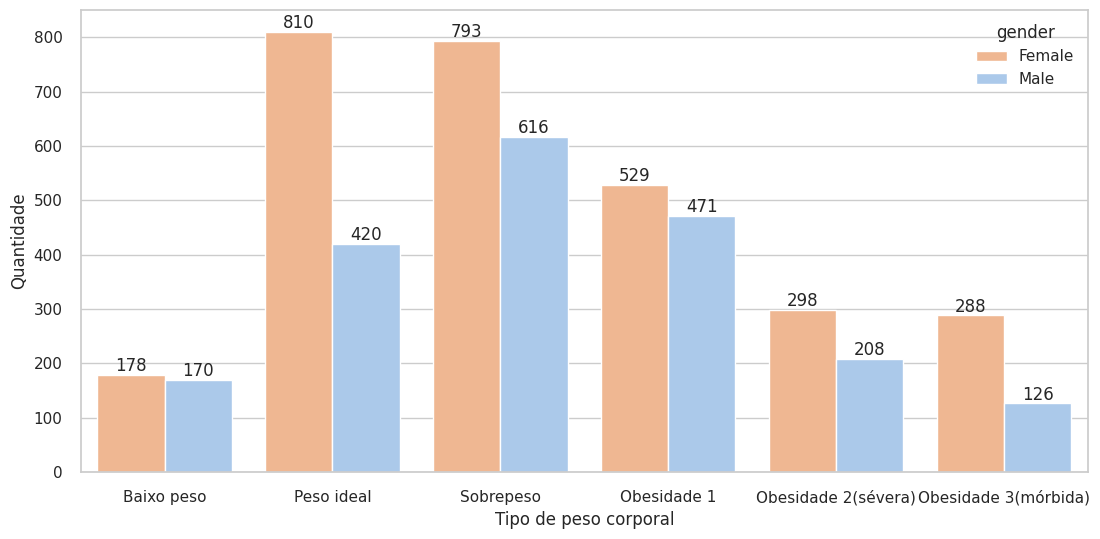

In [282]:
plt.figure(figsize=(13,6))
sea.set_theme(style='whitegrid')
bar = sea.barplot(x = resultado['bmi'],y=resultado['count'],hue=resultado['gender'],palette=sea.color_palette('pastel',n_colors=2)[::-1])
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
plt.ylabel('Quantidade')
plt.xlabel('Tipo de peso corporal')
plt.show()

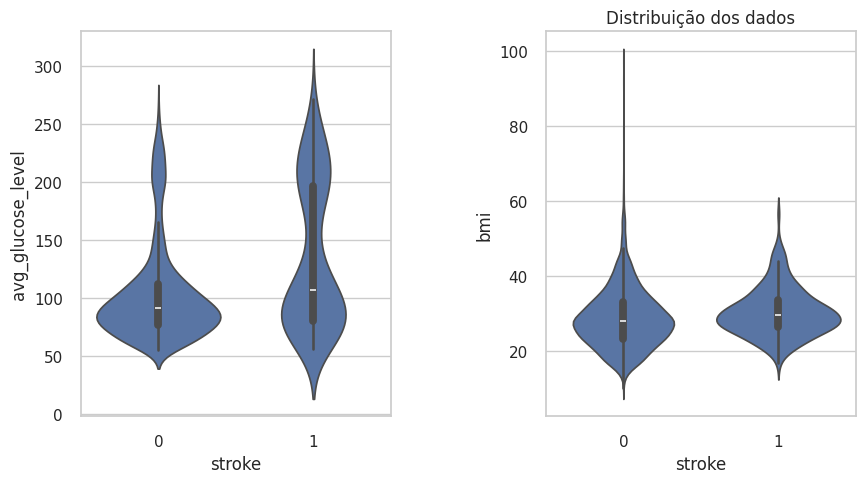

In [283]:
densidade = data[['avg_glucose_level','bmi','stroke']]

fig , ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)

fig.subplots_adjust(wspace=0.5)
sea.violinplot(x = densidade['stroke'],y = densidade['avg_glucose_level'] ,ax=ax[0])
sea.violinplot(x = densidade['stroke'],y = densidade['bmi'],ax=ax[1])
plt.title('Distribuição dos dados')
plt.show()

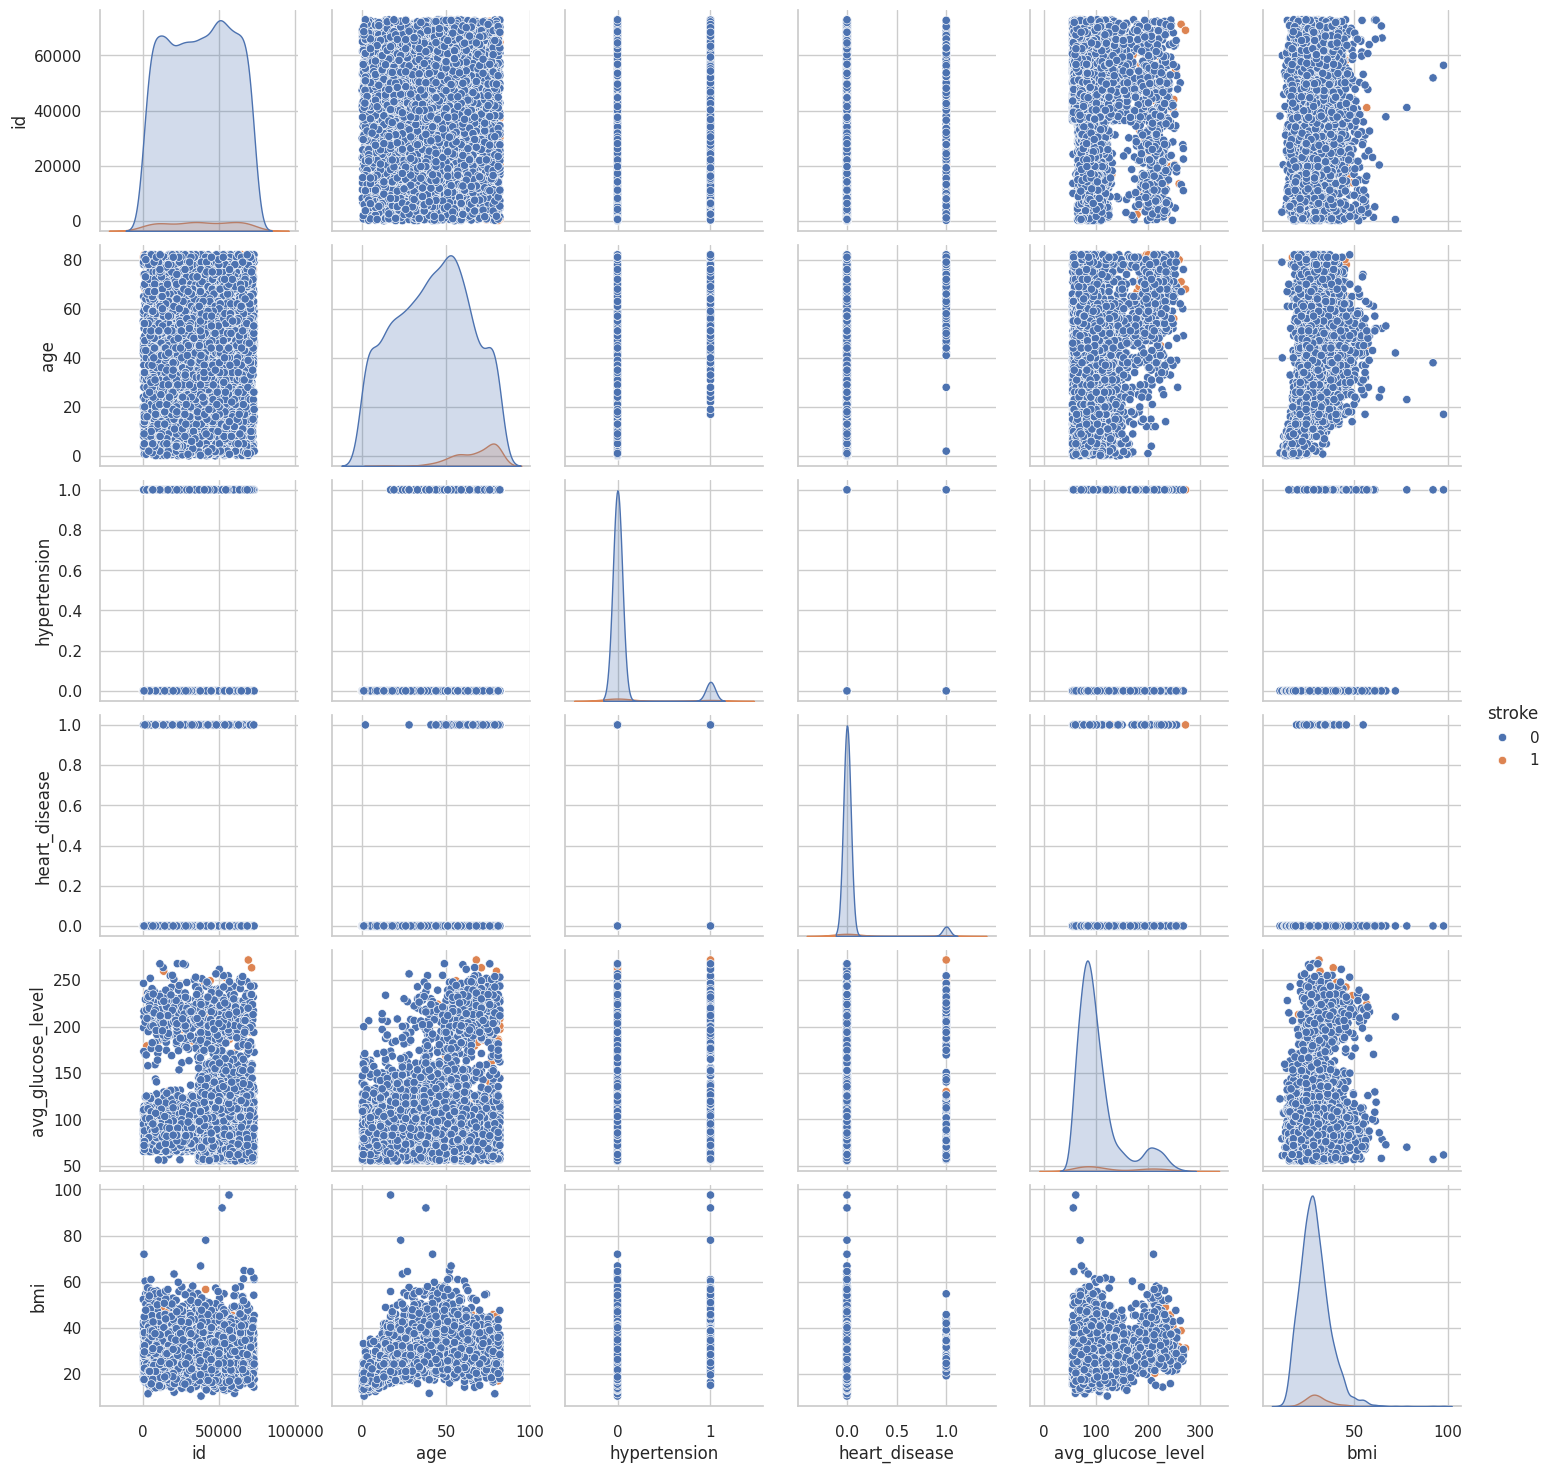

In [284]:
sea.pairplot(data,hue='stroke')
plt.show()

&nbsp;

&nbsp;

# Pré-processamento

In [285]:
from sklearn.preprocessing   import LabelBinarizer,StandardScaler,MinMaxScaler,LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.metrics.pairwise import paired_distances
from sklearn.impute import SimpleImputer

In [286]:
dataset = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv')

In [287]:
dataset.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### Transformação de dados

In [288]:
classGender  = LabelBinarizer()
classMaried  = LabelBinarizer()
classResidence = LabelBinarizer()

dataset['gender']       = classGender.fit_transform(dataset['gender'])
dataset['ever_married'] = classMaried.fit_transform(dataset['ever_married'])
dataset['Residence_type'] = classResidence.fit_transform(dataset['Residence_type'])

In [289]:
dataset = pd.get_dummies(dataset,columns=['smoking_status','work_type'],dtype=int)

In [290]:
dataset.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,51676,1,61.0,0,0,1,0,202.21,NaN,1,0,0,1,0,0,0,0,1,0
2,31112,0,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0,0


### Limpeza de dados

Removendo o valor other do atributo gender

In [291]:
dataset.drop( index = dataset.loc[dataset['gender']=='Other'].index , inplace=True)

Removendo atributo  `id` pois ele e chave estrangeira

In [292]:
dataset.drop(columns='id',inplace=True)

#### Discretização
Tratando os dados nulos , irei transformar atributo numérico bmi em categorico 

&nbsp;

|             |                |
| ----------- |----------------|
|  < 18.5     | baixo peso     |
| 18.5 - 24.9 | peso ideal     |
| 24.9 - 29.9 | Sobrepeso      |
| 30.0 - 34.9 | obesidade 1    |
| 35.0 - 39.9 | Obesidade (Sévera) |
| 40   >      | Obesidade (Mórbida) |

&nbsp;
> Isso está sendo feito por que os atributos bmi tem outlier (muitos) e para tratar se torna dificil melhor colocar os valores em determinado tipo categoricos de peso corporal

In [293]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]

In [294]:
freq = pd.cut(x = dataset['bmi'], bins = bins, labels=labels )

In [295]:
dataset = pd.concat([freq,dataset.drop(columns='bmi')],axis=1)

In [296]:
fig = SimpleImputer(strategy='most_frequent')
dataset['bmi'] = fig.fit_transform(dataset)[:,0]

A ideia é imputar dados em atributo `bmi`,contudo atribuir sobrepeso para pessoas com idade <= 18 não faz sentido,pois esses dados em sua maioria tem valores para pessoas que não tiveram Avc. 
Irei também remover  atributo `work_type_children` 

In [297]:
dataset.loc[( dataset['age']<=18 )]['stroke'].value_counts()

stroke
0    914
1      2
Name: count, dtype: int64

Mostra que dados desse tipo são irrelevantes para classificação

In [298]:
dataset.loc[dataset['work_type_children']==1]['stroke'].value_counts()

stroke
0    685
1      2
Name: count, dtype: int64

Crianças que tiveram AVC são muitos poucas 

In [299]:
index1 = dataset.loc[ ( dataset['age']<=18 )].index
dataset.drop(index=index1,inplace=True)

index2 = dataset.loc[dataset['work_type_children']==1]['stroke'].index
dataset.drop(index=index2,inplace=True)

dataset.drop(columns='work_type_children',inplace=True)

Fazendo LabelEncoder para o atributo `bmi`

In [300]:
dataset['bmi'] = LabelEncoder().fit_transform(dataset['bmi'])

In [301]:
dataset[['age','avg_glucose_level','bmi']].corrwith(dataset['stroke'])

age                  0.250469
avg_glucose_level    0.127510
bmi                  0.031432
dtype: float64

In [302]:
dataset = pd.get_dummies( dataset,columns=['bmi','gender','hypertension','heart_disease','ever_married','Residence_type'],dtype=int)

In [303]:
import numpy as np
from scipy.stats import chi2_contingency
def CorrBin(X,Y,namex,namey):
    if (namex==namey):return 0,0
    chi2, p, _, _ = chi2_contingency(pd.crosstab(X,Y))
    if (p>0.1):return f'{namex} <-> {namey}',str(p)
    return f'{namex}','sair'

In [304]:
dicti = dict(
    Atributos  =[],
    Correlação =[]
)
for  _ , row in (dataset.nunique().reset_index().iterrows()):
    if row.values[1] == 2:
        a,atr = CorrBin(dataset[row.values[0]],dataset['stroke'],row.values[0],'stroke')
        dicti['Atributos'].append(a)
        dicti['Correlação'].append(atr)

dados =pd.DataFrame(dicti) 

Padronização dos dados

In [305]:
dataset[['age','avg_glucose_level']] = StandardScaler().fit_transform(dataset[['age','avg_glucose_level']])

&nbsp;

In [306]:
dataset.drop(index = dados.loc[dados['Correlação']=='sair'].index,inplace=True)

&nbsp;

# Classficação

In [307]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score,StratifiedKFold
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.metrics         import *

In [308]:
from yellowbrick.classifier      import ROCAUC
from yellowbrick.model_selection import LearningCurve

In [309]:
from imblearn.under_sampling import RandomUnderSampler

In [310]:
X = dataset.drop(columns=['stroke'])
Y = dataset['stroke']

### Balanceamento de dados
Combinando under com o oversampling

In [311]:
dataset['stroke'].value_counts()

stroke
0    3947
1     237
Name: count, dtype: int64

In [312]:
under = RandomUnderSampler(sampling_strategy={0:237,1:237},random_state=42)

In [313]:
Xunder, Yunder = under.fit_resample(X,Y)

In [314]:
Yunder.value_counts()

stroke
0    237
1    237
Name: count, dtype: int64

In [315]:
xtrain, xtest, ytrain, ytest = train_test_split(Xunder.values,Yunder.values,test_size=0.25,random_state=42) 

## KNN

In [316]:
params = dict(
    n_neighbors= [5,7,10,12],
    weights   = ['uniform', 'distance'] ,
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
    leaf_size = [30,50],
    p         = [2,3,5,7],
)

gridKnn = GridSearchCV(
    estimator = KNeighborsClassifier() ,
    param_grid=params,
    scoring='accuracy'
)

In [317]:
gridKnn.fit(xtrain,ytrain)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 50], 'n_neighbors': [5, 7, 10, 12],
                         'p': [2, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [318]:
print('Melhor estimador:\n',gridKnn.best_estimator_)

Melhor estimador:
 KNeighborsClassifier(n_neighbors=10, p=5)


In [319]:
gridKnn.best_score_

0.7098591549295775

In [320]:
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=12, p=3)

In [321]:
knn.fit(xtrain,ytrain)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=12, p=3)

In [322]:
pred = knn.predict(xtest)

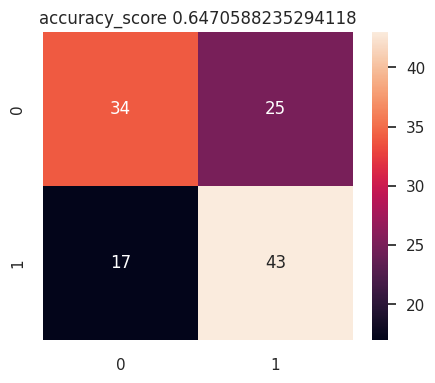

In [323]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [324]:
print(f'f1_score :{f1_score(ytest,pred)}')
print(f'recall   :{recall_score(ytest,pred)}')

f1_score :0.671875
recall   :0.7166666666666667


In [325]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.63      0.72      0.67        60

    accuracy                           0.65       119
   macro avg       0.65      0.65      0.65       119
weighted avg       0.65      0.65      0.65       119



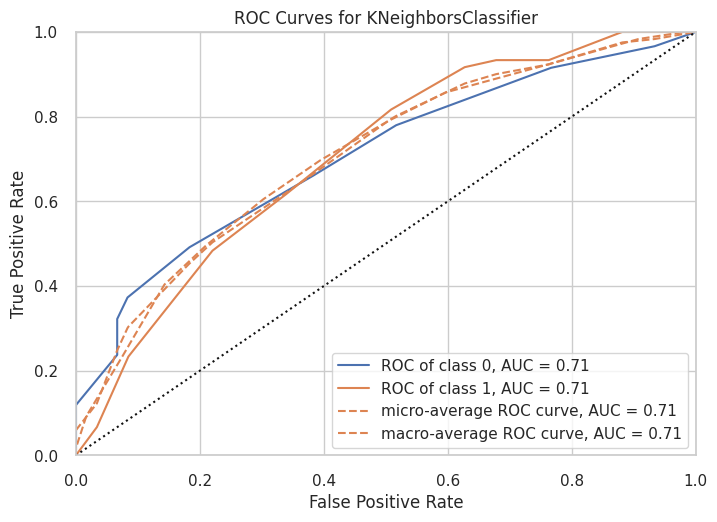

In [326]:
os = ROCAUC(knn)
os.fit(xtrain,ytrain)
os.score(xtest,ytest)
os.show()
plt.show()

## Regressão Logistica

In [327]:
params = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    max_iter= [100,350,500,700,1000]
)
gridLogistic = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid= params,
    scoring   = 'accuracy'
) 

In [328]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore',category=FitFailedWarning)

In [329]:
gridLogistic.fit(xtrain,ytrain)

/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 350, 500, 700, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [330]:
print('Melhor Estimador :\n',gridLogistic.best_estimator_)

Melhor Estimador :
 LogisticRegression()


In [331]:
gridLogistic.best_score_

0.7211267605633803

In [332]:
pred =  LogisticRegression(penalty='l1', solver='liblinear').fit(xtrain,ytrain).predict(xtest)

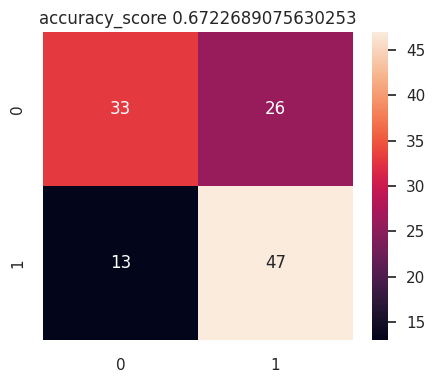

In [333]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [334]:
print(f'f1_score :{f1_score(ytest,pred)}')
print(f'recall   :{recall_score(ytest,pred)}')

f1_score :0.7067669172932332
recall   :0.7833333333333333


In [335]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        59
           1       0.64      0.78      0.71        60

    accuracy                           0.67       119
   macro avg       0.68      0.67      0.67       119
weighted avg       0.68      0.67      0.67       119



> Não obtive bons resultados usando a discretização do atributo `bmi` e nem a imputação de dados 

## Classificação sem discretização

In [336]:
dataset = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv')

In [337]:
dataset.dropna(inplace=True)

In [338]:
classGender  = LabelBinarizer()
classMaried  = LabelBinarizer()
classResidence = LabelBinarizer()

dataset['gender']       = classGender.fit_transform(dataset['gender'])
dataset['ever_married'] = classMaried.fit_transform(dataset['ever_married'])
dataset['Residence_type'] = classResidence.fit_transform(dataset['Residence_type'])

In [339]:
dataset['smoking_status'] = LabelEncoder().fit_transform(dataset['smoking_status'])
dataset['work_type']      = LabelEncoder().fit_transform(dataset['work_type'])

In [340]:
dataset.drop(columns='id',inplace=True)

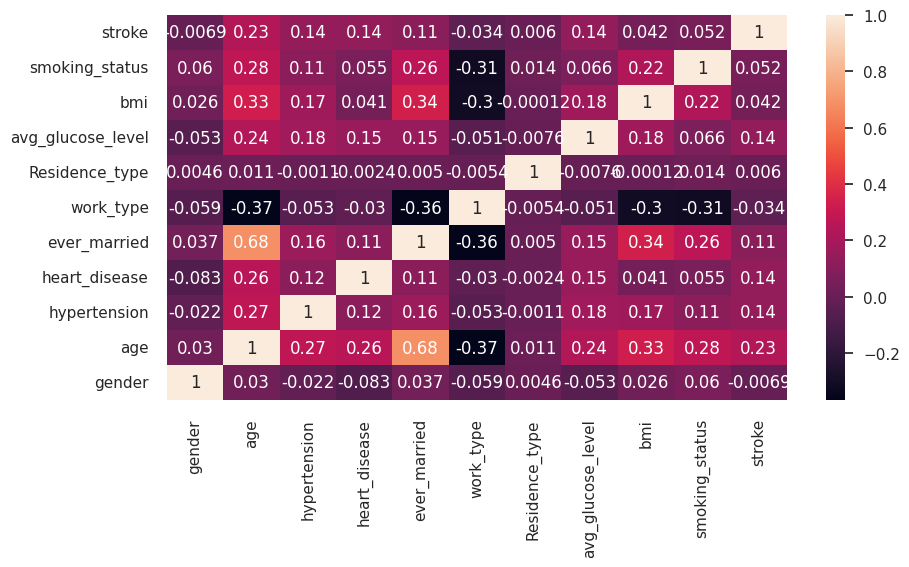

In [341]:
plt.figure(figsize=(10,5))
sea.heatmap(dataset.corr()[::-1],annot=True,fmt='.2g')
plt.show()

 Normalização

In [342]:
dataset[['age','avg_glucose_level','bmi']] = MinMaxScaler().fit_transform(dataset[['age','avg_glucose_level','bmi']])

get_dummies

In [343]:
dataset = pd.get_dummies(dataset,columns=['work_type','smoking_status'],dtype=int)

undersampling

In [344]:
X = dataset.drop(columns=['stroke'])
Y = dataset['stroke']

In [345]:
xunder , yunder = RandomUnderSampler().fit_resample(X,Y)

In [346]:
under = RandomUnderSampler(sampling_strategy={0:237,1:237},random_state=42)

In [347]:
xtrain, xtest, ytrain, ytest = train_test_split(xunder.values,yunder.values,test_size=0.30,random_state=42) 

&nbsp;

In [348]:
params = dict(
    n_neighbors= [5,7,10,12],
    weights   = ['uniform', 'distance'] ,
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
    leaf_size = [30,50],
    p         = [2,3,5,7],
)

gridKnn = GridSearchCV(
    estimator = KNeighborsClassifier() ,
    param_grid=params,
    scoring='accuracy'
)

In [349]:
gridKnn.fit(xtrain,ytrain)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 50], 'n_neighbors': [5, 7, 10, 12],
                         'p': [2, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [350]:
print(gridKnn.best_estimator_)

KNeighborsClassifier(n_neighbors=12, weights='distance')


In [351]:
knn = KNeighborsClassifier(n_neighbors=12).fit(xtrain,ytrain).predict(xtest)

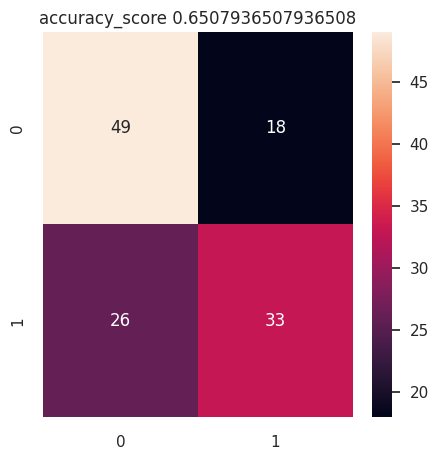

In [352]:
plt.figure(figsize=(5,5))
sea.heatmap(confusion_matrix(ytest,knn),annot=True)
plt.title(f'accuracy_score {accuracy_score(ytest,knn)}')
plt.show()

In [353]:
params = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    max_iter= [100,350,500,700,1000]
)
gridLogistic = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid= params,
    scoring   = 'accuracy'
) 

In [354]:
gridLogistic.fit(xtrain,ytrain)

/home/mateus/MEGA/Projetos/MLPredictionCluster/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan 0.76364699        nan        nan        nan 0.76709527
 0.74658095 0.75002922 0.74658095 0.74658095 0.74658095 0.74658095
        nan        nan        nan        nan        nan        nan
        nan 0.76364699        nan        nan        nan 0.76709527
 0.74658095 0.75002922 0.74658095 0.74658095 0.74658095 0.74658095
        nan        nan        nan        nan        nan        nan
        nan 0.76364699        nan        nan        nan 0.76709527
 0.74658095 0.75002922 0.74658095 0.74658095 0.74658095 0.74658095
        nan        nan        nan        nan        nan        nan
        nan 0.76364699        nan        nan        nan 0.76709527
 0.74658095 0.75002922 0.74658095 0.74658095 0.74658095 0.74658095
        nan        nan        nan        nan        nan        nan
        nan 0.7

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 350, 500, 700, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [355]:
print(gridLogistic.best_estimator_)

LogisticRegression(penalty='l1', solver='saga')


In [356]:
pred = LogisticRegression(penalty='l1', solver='liblinear').fit(xtrain,ytrain).predict(xtest)

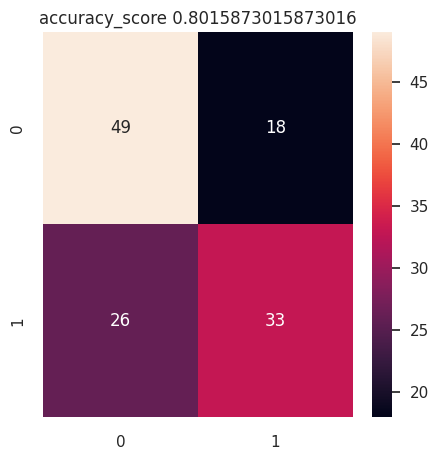

In [357]:
plt.figure(figsize=(5,5))
sea.heatmap(confusion_matrix(ytest,knn),annot=True)
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()